## Необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb

## Загрузка и обработка данных

Загрузим данные о дневной температуре в зависимости от города. В датасете представлены следующие колонки: Country, City, Month, Day, Year, AvgTemperature. Поскольку датасет по электроэнергии собран в Америке, отфильтруем остальные страны из датасета. После фильтрации сгруппируем строки с различными городами по дате и высчитаем для каждой группы среднее. Таким образом мы получили среднюю температуру по стране.

In [2]:
df = pd.read_csv(
    "data/city_temperature.csv",
    usecols=["Country", "State", "City", "Month", "Day", "Year", "AvgTemperature"],
)
df = df[(df.Country == "US") & (df.State == "Ohio")]
temps = df.groupby(["Year", "Month", "Day"]).AvgTemperature.mean()
temps

C:\Users\user\AppData\Local\Temp\ipykernel_16768\76870865.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


Year  Month  Day
1995  1      1      40.100000
             2      22.200000
             3      20.942857
             4      13.500000
             5       8.500000
                      ...    
2020  5      9      38.228571
             10     47.742857
             11     42.071429
             12     45.785714
             13     46.685714
Name: AvgTemperature, Length: 9265, dtype: float64

Загрузим данные по потреблению электроэнергии. В датасете представлены две колонки: Datetime и AEP_MW (Usage). В колонке Datetime находится дата-время измерения с разрешением в 1 час, а в колонке Usage мнгновенная мощность (МВт) в момент времени Datetime. Для выделения признаков добавим колонки Year, Month, Day, Hour, Dayofmonth и Dayofweek. Далее объединим получившийся датасет с данными по температуре, полученными на предыдущем шаге.

In [3]:
df = (
    pd.read_csv("data/DAYTON_hourly.csv", index_col="Datetime", parse_dates=True)
    .rename(columns={"DAYTON_MW": "Usage"})
    .sort_values("Datetime")
)
df_index: pd.DatetimeIndex = df.index  # type: ignore

df["Year"] = df_index.year
df["Month"] = df_index.month
df["Day"] = df_index.dayofyear
df["Hour"] = df_index.hour
df["Dayofweek"] = df_index.dayofweek
df["Dayofmonth"] = df_index.day

df = df.join(temps, on=["Year", "Month", "Dayofmonth"], how="inner")
df

,Usage,Year,Month,Day,Hour,Dayofweek,Dayofmonth,AvgTemperature
Datetime,,,,,,,,
2004-10-01 01:00:00,1621.0,2004,10,275,1,4,1,57.928571
2004-10-01 02:00:00,1536.0,2004,10,275,2,4,1,57.928571
2004-10-01 03:00:00,1500.0,2004,10,275,3,4,1,57.928571
2004-10-01 04:00:00,1434.0,2004,10,275,4,4,1,57.928571
2004-10-01 05:00:00,1489.0,2004,10,275,5,4,1,57.928571
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,2554.0,2018,8,214,20,3,2,72.500000
2018-08-02 21:00:00,2481.0,2018,8,214,21,3,2,72.500000
2018-08-02 22:00:00,2405.0,2018,8,214,22,3,2,72.500000


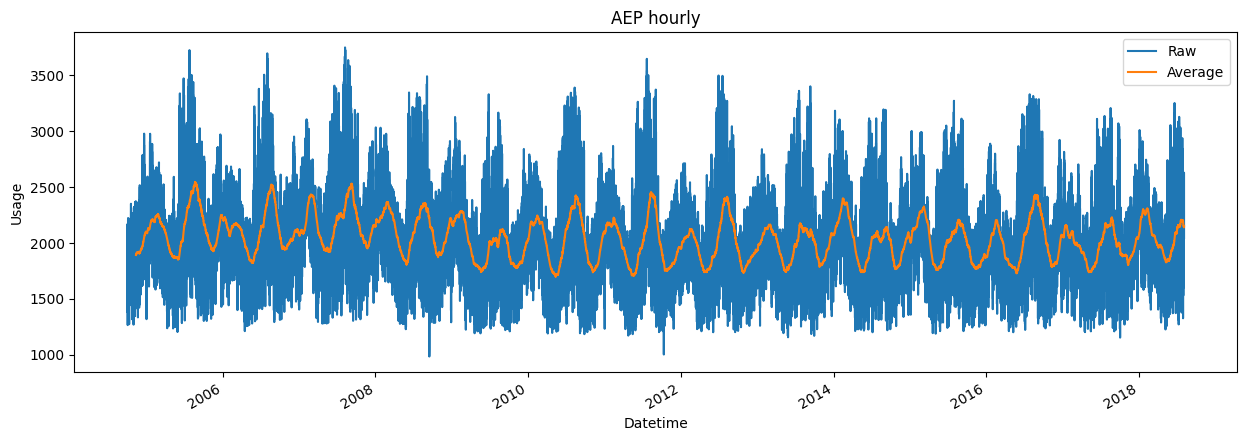

In [4]:
df["Usage"].plot(
    figsize=(15, 5),
    title="AEP hourly",
    xlabel="Datetime",
    ylabel="Usage",
    label="Raw",
    legend=True,
)
df["Usage"].rolling(window=1000).mean().plot(
    figsize=(15, 5),
    label="Average",
    legend=True,
)
plt.show()

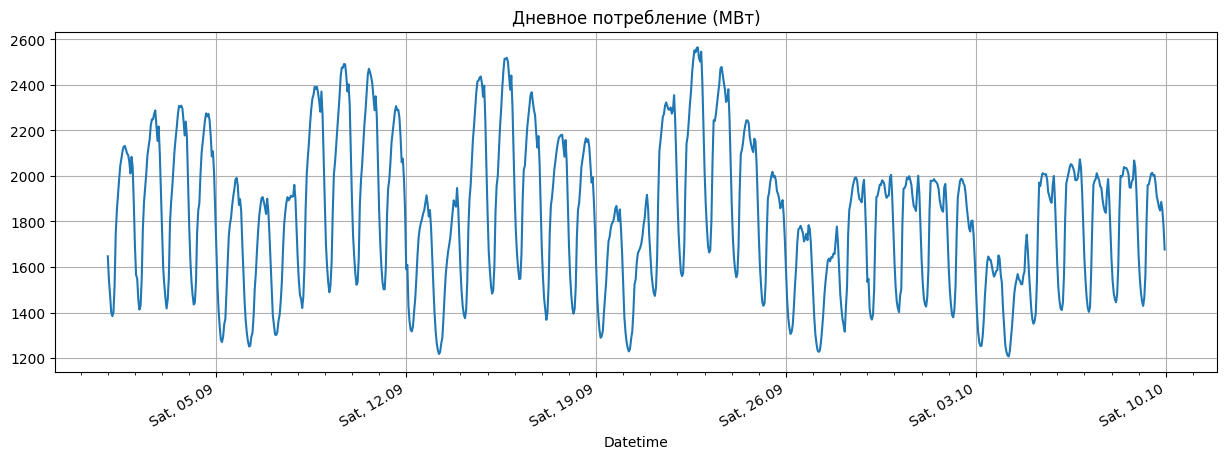

In [5]:
zoomed = df[(df.index >= "09.01.2009") & (df.index < "10.10.2009")]
ax = zoomed["Usage"].plot(
    figsize=(15, 5),
    title="Дневное потребление (МВт)",
    x_compat=True,
    grid=True,
)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%a, %d.%m"))

plt.show()

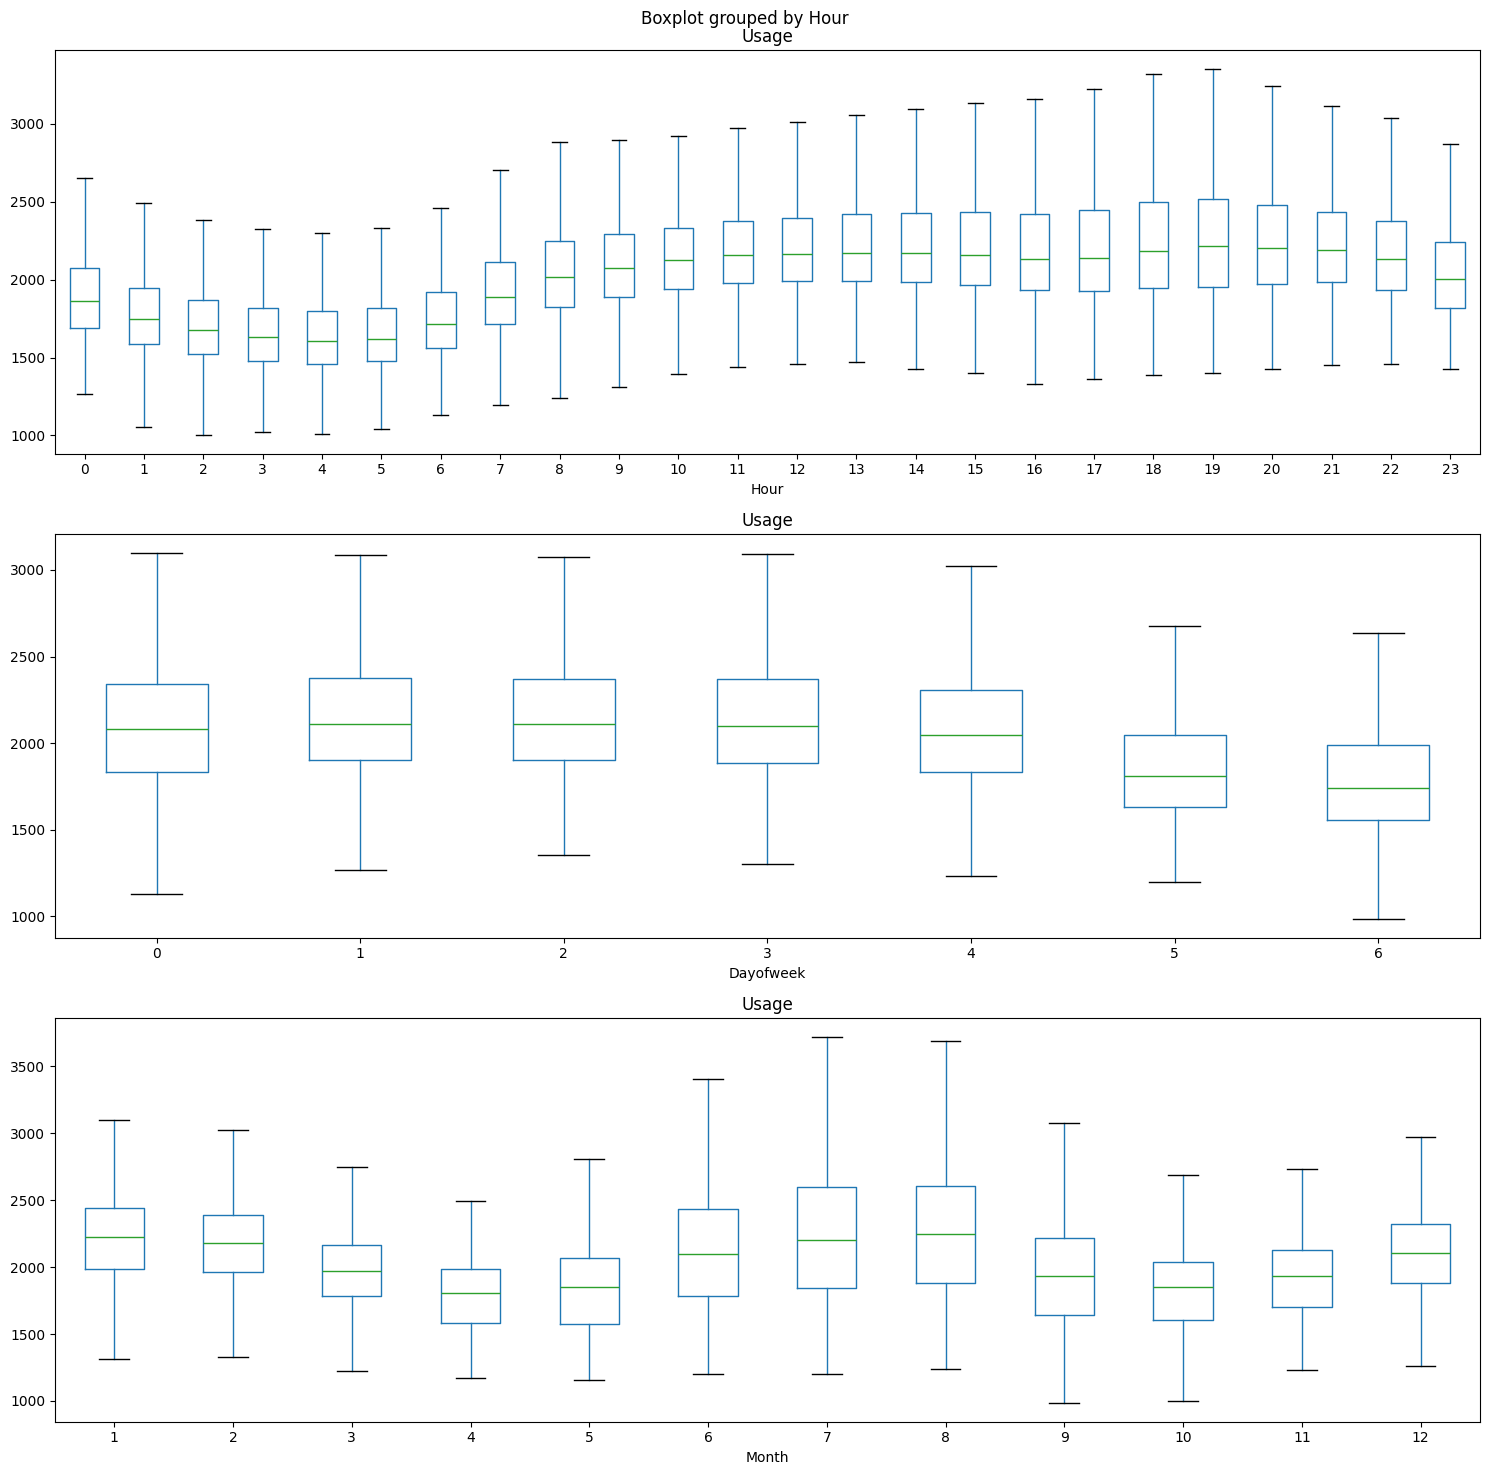

In [6]:
fig, ax = plt.subplots(figsize=(15, 15), nrows=3)
df.boxplot(ax=ax[2], column="Usage", by="Month", grid=False, showfliers=False)
df.boxplot(ax=ax[1], column="Usage", by="Dayofweek", grid=False, showfliers=False)
df.boxplot(ax=ax[0], column="Usage", by="Hour", grid=False, showfliers=False)
fig.tight_layout()

plt.show()

## Подготавливаем модель

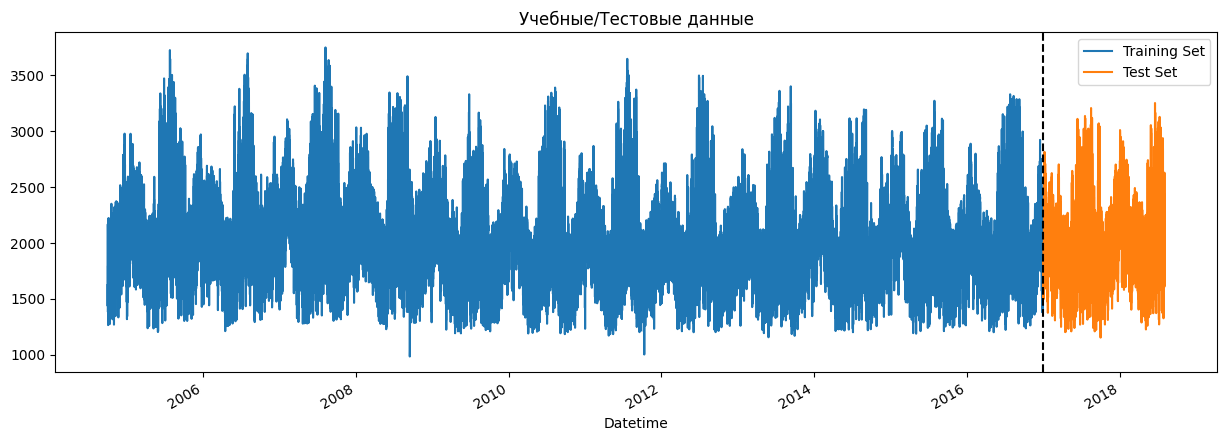

In [7]:
split_point = "01-01-2017"
FEATURES = ["Year", "Month", "Day", "Hour", "Dayofweek", "Dayofmonth", "AvgTemperature"]
TARGET = "Usage"

train = df.loc[df.index < split_point]
test = df.drop(train.index)

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

fig, ax = plt.subplots(figsize=(15, 5))
train["Usage"].plot(ax=ax, label="train", title="Учебные/Тестовые данные")
test["Usage"].plot(ax=ax, label="test")
ax.axvline(split_point, color="black", ls="--")
ax.legend(["Training Set", "Test Set"])

plt.show()

In [25]:
reg = xgb.XGBRegressor(
    n_jobs=8,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=50,
    objective="reg:squarederror",
    max_depth=5,
    learning_rate=0.01,
)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

test["Prediction"] = reg.predict(X_test)

[0]	validation_0-rmse:393.88212	validation_1-rmse:362.36073
[100]	validation_0-rmse:217.60048	validation_1-rmse:195.14077
[200]	validation_0-rmse:158.63559	validation_1-rmse:148.54888
[300]	validation_0-rmse:135.15945	validation_1-rmse:134.60612
[400]	validation_0-rmse:124.01467	validation_1-rmse:128.40421
[500]	validation_0-rmse:116.18807	validation_1-rmse:123.74928
[600]	validation_0-rmse:111.02957	validation_1-rmse:120.98416
[700]	validation_0-rmse:107.27036	validation_1-rmse:119.22571
[800]	validation_0-rmse:103.93106	validation_1-rmse:117.42217
[900]	validation_0-rmse:101.93144	validation_1-rmse:116.46335
[999]	validation_0-rmse:99.84371	validation_1-rmse:115.54727


## Важность признаков

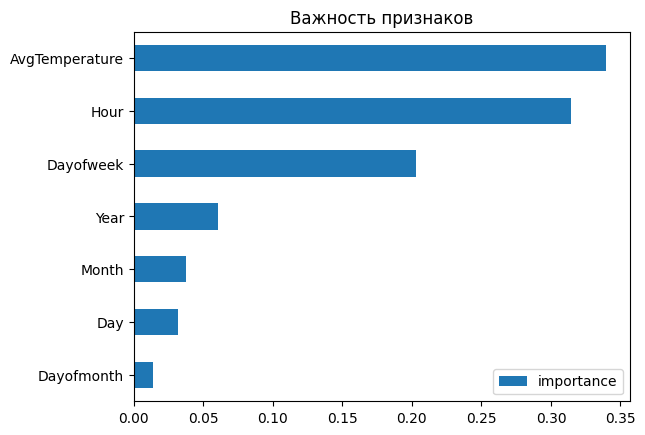

In [26]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"],
)
fi.sort_values("importance").plot(kind="barh", title="Важность признаков")

plt.show()

## Предсказание данных

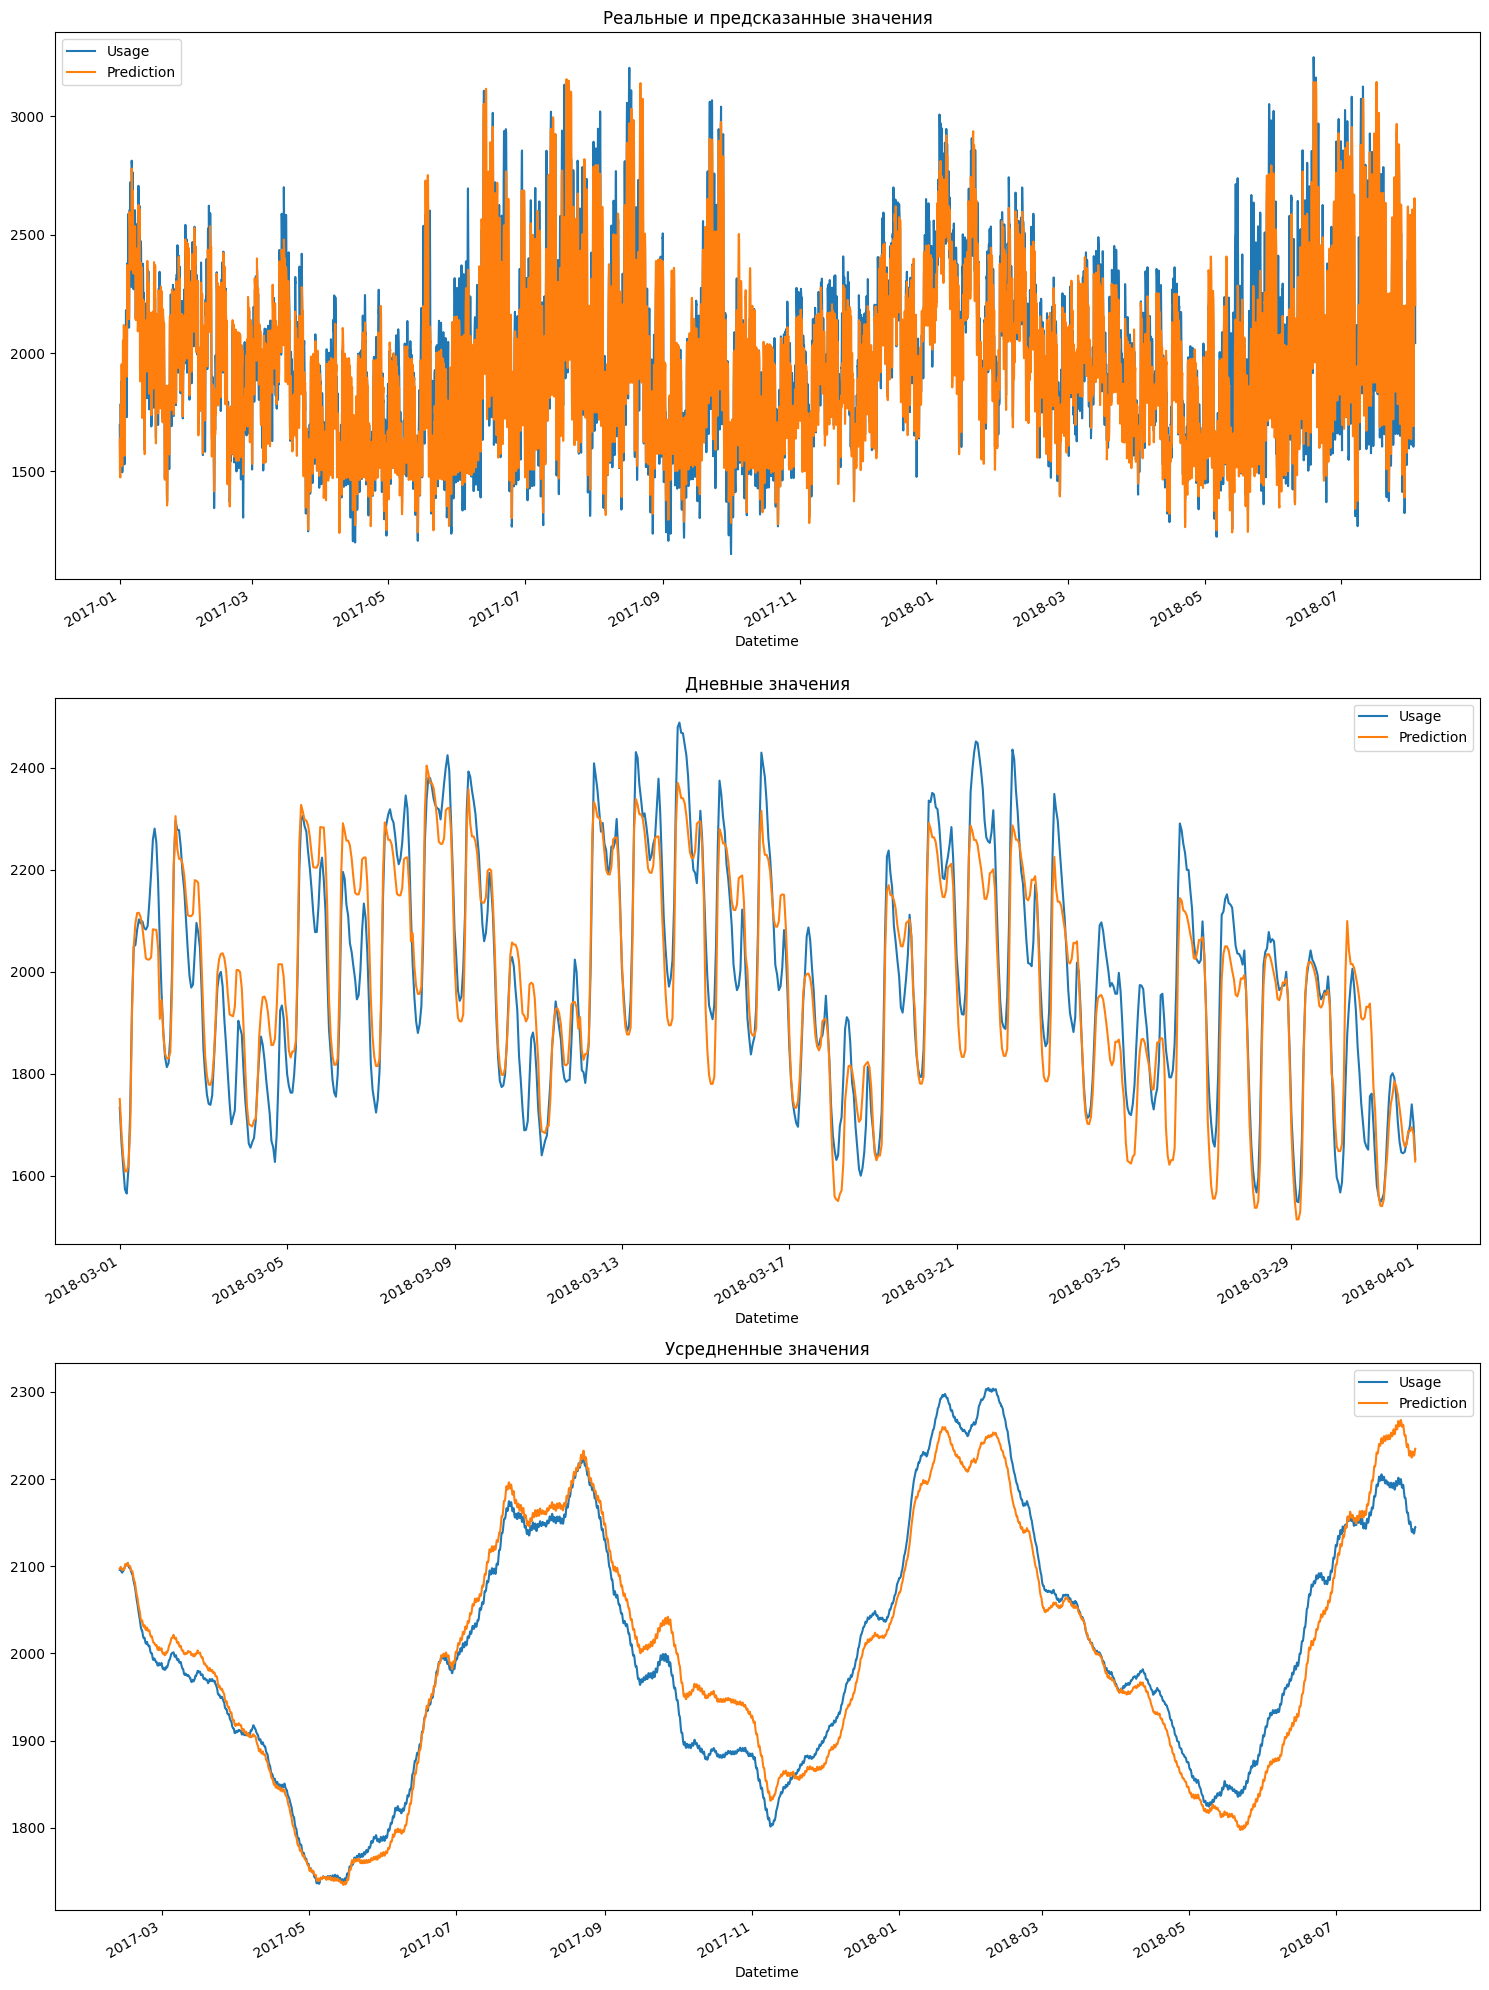

In [27]:
fig, ax = plt.subplots(figsize=(15, 20), nrows=3)

combined = test[["Usage", "Prediction"]]
comb_zoomed = combined[
    (combined.index >= "03.01.2018") & (combined.index < "04.01.2018")
]
mean_avg = combined.rolling(window=1000).mean()

combined.plot(ax=ax[0], title="Реальные и предсказанные значения")
comb_zoomed.plot(ax=ax[1], title="Дневные значения")
mean_avg.plot(ax=ax[2], title="Усредненные значения")

fig.tight_layout()
plt.show()